In [18]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pylab import *

%matplotlib inline

from pandas import DataFrame

In [19]:
from sklearn import linear_model, cross_validation
from math import sqrt

In [25]:
df = pd.read_csv("energy_efficiency.csv")
col=[10,11]
df.drop(df.columns[col], axis=1, inplace=True)
df.dropna(how="all", inplace=True)

yCols = [8,9]

X = df.drop(["Y1", "Y2"], axis=1)
X = np.array(X)

y = df[["Y1", "Y2"]]
y = np.array(y)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.1)

In [42]:
#Least-Angle-Regression (LARS)

#normalization

nrows = len(X)
ncols = len(X[0])

xMeans = []
xStd = []
for i in range(ncols):
    col = [X[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = [(X[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    xStd.append(stdDev)
    
xNormalized = []
for i in range(nrows):
    rowNormalized = [(X[i][j] - xMeans[j] ) /xStd[j] for j in range(ncols)]
    xNormalized.append(rowNormalized)
    
ycols=len(y[0])
yMeans = []
yStd = []

for i in range(ycols):
    col = [y[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    yMeans.append(mean)
    colDiff = [(y[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    yStd.append(stdDev)
    

# yMeans = sum(y)/nrows
# yStd = sqrt(sum([(y[i] - yMean)*(y[i] - yMean) for i in range(nrows)])/nrows)

yNormalized = []
for i in range(nrows):
    rowNormalized  = [(y[i][j] - yMeans[j])/ yStd[j] for j in range(ycols)]
    yNormalized.append(rowNormalized)   
    
print(nrows, ncols)



768 8


In [53]:
#beta = coefficient that minimizes the error of the linear regression

beta = [0.0] * ncols
betaMat = []
betaMat.append(list(beta))

nSteps = 500
stepSize = 0.004

for i in range(nSteps):
    residuals = [0.0] * nrows
    
    for j in range(nrows):
        yHat = sum([xNormalized[j][k] * beta[k] for k in range(ncols)])
        residuals[j] = yNormalized[j] - yHat
        
    #correlation
    corr = [0.0] * ncols
    for j in range(ncols):
        corr[j] = sum([xNormalized[k][j] * residuals[k] for k in range(nrows)]) / nrows
        
    iStar = 0
    corrStar = corr[0]
    
    for j in range(1, (ncols)):
        if abs(corrStar) < abs(corr[j]):
            iStar = j
            corrStar = corr[j]
            
    beta[iStar] += stepSize * corrStar / abs(corrStar)
    betaMat.append(list(beta))

C:\Users\mdtar001\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


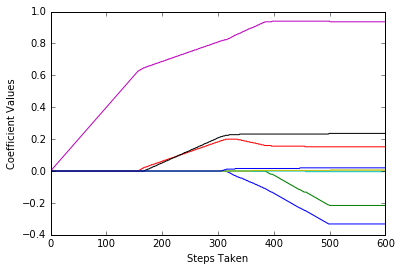

In [52]:
#plot range of beta values for each attribute
for i in range(ncols):
    coefCurve = [betaMat[k][i] for k in range(nSteps)]
    xaxis = range(nSteps)
    plt.plot(xaxis, coefCurve)

plt.xlabel("Steps Taken")
plt.ylabel("Coefficient Values")

plt.legend() #I need to put legend
    
    

In [86]:
#Ten-fold-CV, determining best set of coefficients on LARS algorithm

nxval = 10 #number of cv-folds

errors = []
for i in range(nSteps):
    b = []
    errors.append(b)
    
for ixval in range(nxval):
    idxTest = [a for a in range(nrows) if a%nxval == ixval*nxval]
    idxTrain = [a for a in range(nrows) if a%nxval != ixval*nxval]

    xTrain = [xNormalized[i] for i in idxTrain]
    xTest = [xNormalized[i] for i in idxTest]
    yTrain = [yNormalized[i] for i in idxTrain]
    yTest = [yNormalized[i] for i in idxTest]

    nrowsTrain = len(idxTrain)
    nrowsTest = len(idxTest)

    beta = [0.0] * ncols
    #initialize matrix of betas at each step
    betaMat = []
    betaMat.append(list(beta))

    for iStep in range(nSteps):
        #calculate residuals
        residuals = [0.0] * nrows

        for j in range(nrowsTrain):
            yHat = sum([xTrain[j][k] * beta[k] for k in range(ncols)])
            residuals[j] = yTrain[j] - yHat

        #correlation in between attribute
        corr = [0.0] * ncols

        for j in range(ncols):
            corr[j] = sum([xTrain[k][j] * residuals[k] for k in range(nrowsTrain)]) / nrowsTrain

        iStar = 0
        corrStar = corr[0]
        
        for j in range(1, (ncols)):
            if abs(corrStar) < abs(corr[j]):
                iStar = j
                corrStar = corr[j]

        beta[iStar] += stepSize * corrStar / abs(corrStar)
        betaMat.append(list(beta))
    
        #use beta to determine out of sample error
        for j in range(nrowsTest):
            yHat = sum([xTest[j][k] * beta[k] for k in range(ncols)])
            err = yTest[j] - yHat
            errors[iStep].append(err)    

In [87]:
cvCurve =  []
for errVector in errors:
    mse = sum([x*x for x in errVector])/len(errVector)
    cvCurve.append(mse)
    
minMse = min(cvCurve)
minPt = [i for i in range(len(cvCurve)) if cvCurve[i] == minMse][0]

print("Minimum Mean Square Error", minMse)
print("Index of Minimum Mean Square Error", minPt)   


Minimum Mean Square Error 0.233770529788
Index of Minimum Mean Square Error 493


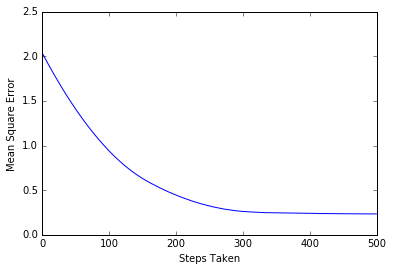

In [89]:
xaxis = range(len(cvCurve))
plt.plot(xaxis, cvCurve)

plt.xlabel("Steps Taken")
plt.ylabel(("Mean Square Error"))